# Sector Volatility Analysis  
*Author: Emmanuel Ocran*  

### 1. Project Overview  
I analyze seven years of historical stock price data from June 1, 2018 to June 1, 2025 to evaluate volatility and risk-adjusted returns across major stock market sectors.  
The goal is to support portfolio decisions by identifying sectors with greater stability or stronger performance during market fluctuations.

#### 1.1 Stocks Used per Sector 
The analysis covers six major sectors with four representative stocks per sector:   

| Sector                 | Tickers                    |
|------------------------|----------------------------|
| Technology             | AAPL, MSFT, NVDA, AMD      |
| Energy                 | XOM, CVX, COP, HAL         |
| Healthcare             | JNJ, PFE, UNH, MRK         |
| Financials             | JPM, BAC, WFC, GS          |
| Consumer Discretionary | AMZN, TSLA, HD, MCD        |
| Utilities              | NEE, DUK, SO, AEP          |


#### 1.2 Key Questions  
- Which sector exhibits the highest level of volatility?  
- Which stocks demonstrate the strongest average returns?  
- How do sectors perform during major events such as the COVID-19 pandemic or inflation shocks?  
- How correlated are the returns between sectors?  
- Which sectors recovered the fastest after major downturns?

#### 1.3 Data Overview  
I collected daily adjusted closing prices using the `yfinance` API for selected stocks in each sector.  
Each sector’s data was saved as a separate CSV file covering the 7-year period.  

This notebook begins by loading and combining the cleaned data. I then compute key features such as daily returns, rolling volatility, and Sharpe ratios to support sector comparisons.


### 2. Load and Combine Sector Data

In this step, I load the individual raw CSV files for each sector, perform initial validation and cleaning, and consolidate them into a single structured DataFrame for analysis.

Key actions performed:

- Defined a reusable `load_sector_data()` function to:
  - Parse date fields correctly
  - Validate presence of required columns (`Date`, `Ticker`, `Close`, `Sector`)
  - Sort the data by ticker and date for consistency  
- Used the `pathlib` module to loop through all sector files in the `data/` directory
- Combined the cleaned datasets into a unified DataFrame using `pd.concat()`
- Saved the resulting DataFrame to the `data/clean/combined_sector_data.csv` for reproducibility and downstream use

This step ensures the raw data is standardized and analysis-ready before proceeding to exploratory analysis and feature engineering.


In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [32]:
# Function to load and clean each file
def load_sector_data(filepath):
    """
    Loads a single sector CSV, checks for structure,
    parses dates, and returns a cleaned DataFrame.
    """
    try:
        df = pd.read_csv(filepath)
        
        # Validate required columns
        required = {'Date', 'Ticker', 'Close', 'Sector'}
        if not required.issubset(df.columns):
            raise ValueError(f"Missing columns in {filepath}")
        
        # Convert date column to datetime and sort
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
        
        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame()

In [33]:
# Combine sectors data and save them into `data/clean` 
# Define data directory
data_dir = Path("../data")
csv_files = list(data_dir.glob("*.csv"))

# Load all sector CSVs
all_sectors = []

for file in csv_files:
    df = load_sector_data(file)
    if not df.empty:
        all_sectors.append(df)

# Combine into a single DataFrame
combined_df = pd.concat(all_sectors, ignore_index=True)

# Save the combined data
output_path = Path("../data/clean/combined_sector_data.csv") # Define output path

# Ensure the parent directory exists
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the file
combined_df.to_csv(output_path, index=False)
print(f"Saved combined file to: {output_path}")


Saved combined file to: ..\data\clean\combined_sector_data.csv


### 3. Data Quality Checks

Before performing any analysis, I validated the integrity and structure of the combined dataset to ensure the reliability of insights derived from it.

The following checks were conducted:

- Verified the absence of missing values across all key columns  
- Confirmed appropriate data types, particularly that the `Date` column is parsed as a datetime object  
- Checked for and removed duplicate records  
- Ensured the presence of all six sectors and the expected number of unique tickers  

These quality checks are critical for maintaining data consistency and minimizing the risk of misleading results during analysis.


In [34]:
# Load combined dataset
data_path = Path("../data/clean/combined_sector_data.csv")
combined_df = pd.read_csv(data_path, parse_dates=["Date"])

# Preview the first few rows
display(combined_df.head())

,Date,Ticker,Close,Sector
0,2018-06-01,AMZN,82.077003,Consumer Discretionary
1,2018-06-04,AMZN,83.263496,Consumer Discretionary
2,2018-06-05,AMZN,84.817497,Consumer Discretionary
3,2018-06-06,AMZN,84.787498,Consumer Discretionary
4,2018-06-07,AMZN,84.464996,Consumer Discretionary


In [35]:
# Display structure and data types
print("Dataset info:")
combined_df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42216 entries, 0 to 42215
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    42216 non-null  datetime64[ns]
 1   Ticker  42216 non-null  object        
 2   Close   42216 non-null  float64       
 3   Sector  42216 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.3+ MB


In [36]:
# Check for duplicate rows
duplicate_count = combined_df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Remove duplicates if any
if duplicate_count > 0:
    combined_df = combined_df.drop_duplicates()
    print("Duplicates removed.")

Duplicate rows: 0


In [37]:
# Check for missing values
print("\nMissing values per column:")
display(combined_df.isna().sum())


Missing values per column:


Date      0
Ticker    0
Close     0
Sector    0
dtype: int64

In [38]:
# Confirm unique tickers and sectors
print("\nUnique tickers:", combined_df['Ticker'].nunique())
print("Unique sectors:", combined_df['Sector'].nunique())

# Check date range
print("Date range:", combined_df['Date'].min().date(), "to", combined_df['Date'].max().date())


Unique tickers: 24
Unique sectors: 6
Date range: 2018-06-01 to 2025-05-30


#### Summary: Data Quality

The dataset passes all key integrity checks and is ready for analysis.

- **Shape:** 42,216 rows × 4 columns (`Date`, `Ticker`, `Close`, `Sector`)  
- **Date Range:** June 1, 2018 → May 30, 2025 — matches the project scope  
- **Uniqueness:** 24 unique tickers across 6 expected sectors  
- **Missing Values:** None found in any column  
- **Duplicates:** No duplicate rows detected  
- **Data Types:** All columns correctly typed (`Date` as `datetime64`, `Close` as `float64`)



### 4. Price Trend Visualization

In this step, I explore how average stock prices have evolved over time across different sectors.  

This helps establish a visual understanding of sector behavior during various market conditions and prepares the ground for deeper volatility and return analysis.

**Tasks:**
- Aggregate data by `Date` and `Sector` to compute average daily `Close` prices  
- Create line plots to visualize sector-wise price trends from 2018 to 2025  
- Highlight major events such as the COVID-19 crash or inflation-driven downturns

In [39]:
# Group by Date and Sector, and calculate average closing price for each sector
avg_close = combined_df.groupby(['Date', 'Sector'])['Close'].mean().reset_index()

# Rename the aggregated column for clarity
avg_close.rename(columns={'Close': 'Average_Close'}, inplace=True)

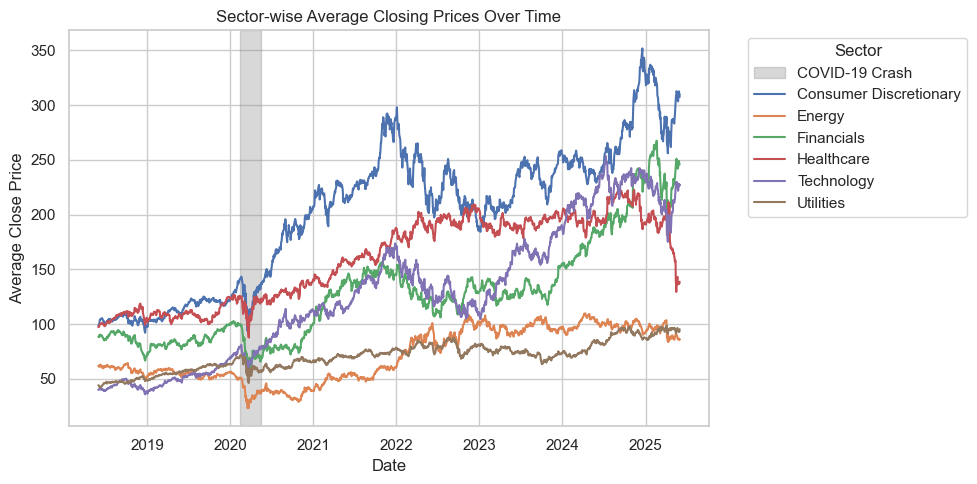

In [40]:
plt.figure(figsize=(10, 5))

# Highlight the COVID-19 crash period using a shaded area
plt.axvspan(pd.to_datetime("2020-02-15"), pd.to_datetime("2020-05-15"), 
            color='gray', alpha=0.3, label='COVID-19 Crash')

# Plot average sector prices over time using seaborn lineplot
sns.lineplot(data=avg_close, x='Date', y='Average_Close', hue='Sector')

# Add plot titles and labels
plt.title('Sector-wise Average Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Average Close Price')

# Place legend outside for better readability
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()

#### Summary: Sector Price Trend 

This line chart illustrates average adjusted closing prices across six sectors from 2018 to 2025.

**Key Observations**
- **Consumer Discretionary** led all sectors in price growth, with a sharp rise starting mid-2020.  
- **Technology** also experienced strong gains but with greater volatility, especially between 2021 and 2024.  
- **Utilities** and **Energy** remained lower and more stable, reflecting their defensive and cyclical characteristics.  
- A noticeable dip across all sectors in early 2020 corresponds to the **COVID-19** market crash.  
- After 2020, sector trajectories diverged, indicating differences in momentum and investor sentiment.

This visualization reveals how sector trends differ in growth and stability, providing useful insights for diversification and risk-aware portfolio decisions.


### 5. Calculate Daily Returns

Daily returns represent the percentage change in a stock’s adjusted closing price from one trading day to the next. This metric is a core building block for measuring risk (volatility) and computing risk-adjusted returns (Sharpe Ratio).

In this step, I will:

- Sort the dataset by `Ticker` and `Date` to ensure time order is preserved
- Use `.groupby('Ticker')` and `.pct_change()` to calculate daily price movements
- Store the result in a new column called `Daily_Return`


In [41]:
# Sort the data by `Ticker` and `Date`
combined_df = combined_df.sort_values(by=['Ticker', 'Date'])

# Group data by Ticker and calculate daily price changes
combined_df['Daily_Return'] = combined_df.groupby('Ticker')['Close'].pct_change()

display(combined_df[['Date', 'Ticker', 'Close', 'Daily_Return']].head())

,Date,Ticker,Close,Daily_Return
28144,2018-06-01,AAPL,45.001362,NaN
28145,2018-06-04,AAPL,45.377460,0.008357
28146,2018-06-05,AAPL,45.727570,0.007715
28147,2018-06-06,AAPL,45.886047,0.003466
28148,2018-06-07,AAPL,45.763050,-0.002680


### 6. Calculate Rolling Volatility

Rolling volatility captures how much a stock's return fluctuates over time within a specified window. This measure is essential for understanding short-term risk exposure and identifying periods of increased uncertainty.

In this step, I will:

- Group the dataset by `Ticker` to ensure independent rolling calculations per stock  
- Apply a 30-day rolling window to the `Daily_Return` column  
- Compute the standard deviation within each window as a proxy for volatility  
- Store the output in a new column named `Rolling_Volatility`  
- Preview results to confirm correctness (initial values will be `NaN` due to window size)


In [42]:
# Ensure data is sorted by Ticker and Date
combined_df = combined_df.sort_values(by=["Ticker", "Date"])

# Calculate 30-day rolling standard deviation of daily returns
combined_df["Rolling_Volatility"] = (
    combined_df.groupby("Ticker")["Daily_Return"]
    .rolling(window=30)
    .std()
    .reset_index(level=0, drop=True)
)

# Preview the result
combined_df[["Date", "Ticker", "Close", "Daily_Return", "Rolling_Volatility"]].sample(5, random_state=42)

,Date,Ticker,Close,Daily_Return,Rolling_Volatility
852,2021-10-19,AMZN,172.207504,-0.000751,0.013208
31555,2024-12-24,AMD,126.290001,0.013563,0.022446
11915,2023-10-27,HAL,38.017025,0.003802,0.021643
37158,2019-04-16,DUK,69.129013,-0.014927,0.006689
1356,2023-10-20,AMZN,125.169998,-0.025156,0.020448


### 7. Calculate Risk-Adjusted Performance (Sharpe Ratio)

In this step, I compute the Sharpe Ratio for each stock to evaluate how effectively it delivers returns relative to its risk. The Sharpe Ratio is a key financial metric used to assess risk-adjusted performance and is widely applied in portfolio management.

**Definition:**

The Sharpe Ratio quantifies the excess return per unit of volatility:

$$
\text{Sharpe Ratio} = \frac{\text{Mean Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Return}}
$$

For simplicity and short-term analysis, I assume a **risk-free rate of 0**.

**Tasks:**

- For each stock (`Ticker`), calculate:
  - Mean of daily returns  
  - Standard deviation of daily returns  

- Compute the Sharpe Ratio using the formula above

- Add the Sharpe Ratio as a new column to a summary DataFrame

- Merge with sector information to group by `Sector`

- Calculate the **average Sharpe Ratio per sector**

- Visualize the results using a bar chart for easy sector-level comparison

This analysis highlights which sectors deliver the best returns per unit of risk, offering insights into stability and performance under market fluctuations.


,Ticker,mean_return,std_return,Sharpe_Ratio,Sector
0,AAPL,0.001051,0.020002,0.052542,Technology
1,AEP,0.000495,0.014408,0.034385,Utilities
2,AMD,0.001761,0.034776,0.050632,Technology
3,AMZN,0.000764,0.022072,0.034616,Consumer Discretionary
4,BAC,0.000544,0.020980,0.025909,Financials


,Sector,Sharpe_Ratio
4,Technology,0.057580
0,Consumer Discretionary,0.043233
5,Utilities,0.036781
2,Financials,0.033568
3,Healthcare,0.019459
1,Energy,0.018264


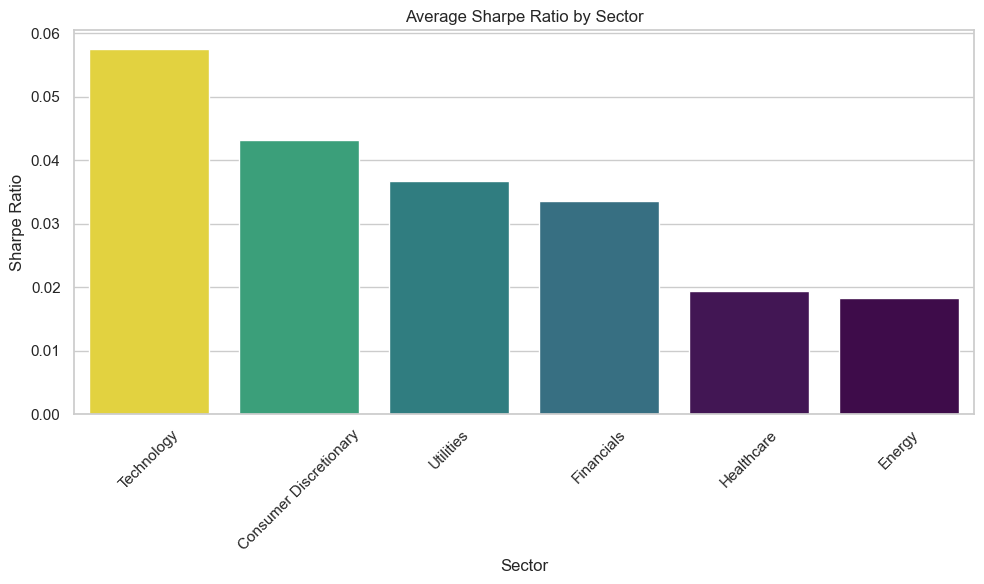

In [43]:
# Group by Ticker to calculate mean and standard deviation of daily returns
sharpe_stats = combined_df.groupby('Ticker')['Daily_Return'].agg(
    mean_return='mean',
    std_return='std'
).reset_index()

# Compute Sharpe Ratio assuming a risk-free rate of 0
sharpe_stats['Sharpe_Ratio'] = sharpe_stats['mean_return'] / sharpe_stats['std_return']

# Map each Ticker to its Sector
ticker_sector_map = combined_df[['Ticker', 'Sector']].drop_duplicates()
sharpe_stats = sharpe_stats.merge(ticker_sector_map, on='Ticker')

# Calculate average Sharpe Ratio by Sector
sector_sharpe = sharpe_stats.groupby('Sector')['Sharpe_Ratio'].mean().reset_index()
sector_sharpe = sector_sharpe.sort_values(by='Sharpe_Ratio', ascending=False)

# Merge Sharpe Ratio back into combined_df for further use
combined_df = combined_df.merge(
    sharpe_stats[['Ticker', 'Sharpe_Ratio']],
    on='Ticker',
    how='left'
)

# Preview results
display(sharpe_stats.head())
display(sector_sharpe)

# Visualize Average Sharpe Ratio per Sector
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sector_sharpe,
    x='Sector',
    y='Sharpe_Ratio',
    palette='viridis',
    hue='Sharpe_Ratio',
    legend=False
)
plt.title('Average Sharpe Ratio by Sector')
plt.xticks(rotation=45)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Sector')
plt.tight_layout()
plt.show()


#### Summary: Average Sharpe Ratio by Sector

The bar chart illustrates the **average Sharpe Ratio** for each sector over the period **2018–2025**, providing a measure of **risk-adjusted performance**.

- The **Technology sector** achieved the highest Sharpe Ratio, indicating it offered the most favorable return relative to its volatility.
- **Consumer Discretionary** and **Utilities** also demonstrated relatively strong risk-adjusted returns.
- **Energy** and **Healthcare** exhibited the lowest Sharpe Ratios, suggesting lower return efficiency per unit of risk.

These insights are critical for **portfolio optimization**, as they help identify sectors that historically provided **strong performance relative to risk**.


### 8. Sector Comparisons and Insights

This step presents a cross-sector comparison based on three fundamental performance metrics:

- **Average Volatility**: Measures the average 30-day rolling standard deviation of daily returns, indicating short-term risk.
- **Average Daily Return**: Reflects the mean of daily percentage changes in price, representing overall return performance.
- **Sharpe Ratio**: Assesses risk-adjusted performance by comparing average return to its volatility.

These metrics are visualized using **bar charts** and **box plots** to highlight differences in return consistency, risk exposure, and efficiency across sectors.

The goal is to identify which sectors consistently offer better return profiles relative to risk — a critical input for strategic portfolio allocation.

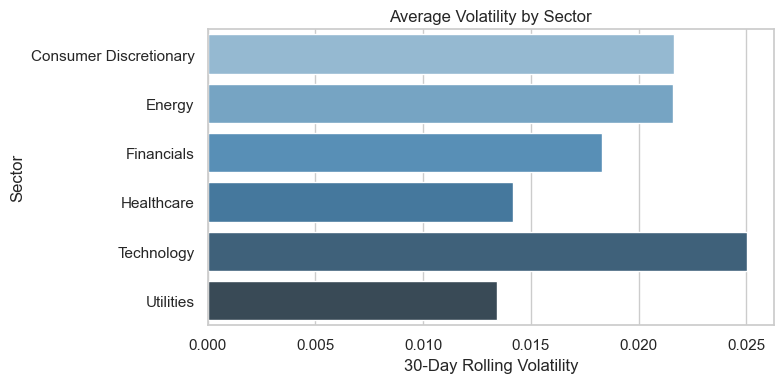

In [44]:
# Set seaborn theme
sns.set_theme(style="whitegrid")

# Group by Sector and compute means
sector_summary = combined_df.groupby("Sector").agg({
    "Rolling_Volatility": "mean",
    "Daily_Return": "mean",
    "Sharpe_Ratio": "mean"
}).reset_index()

# Plot: Average Rolling Volatility
plt.figure(figsize=(8, 4))
sns.barplot(data=sector_summary, x="Rolling_Volatility", y="Sector", palette="Blues_d", hue="Sector", legend=False)
plt.title("Average Volatility by Sector")
plt.xlabel("30-Day Rolling Volatility")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()


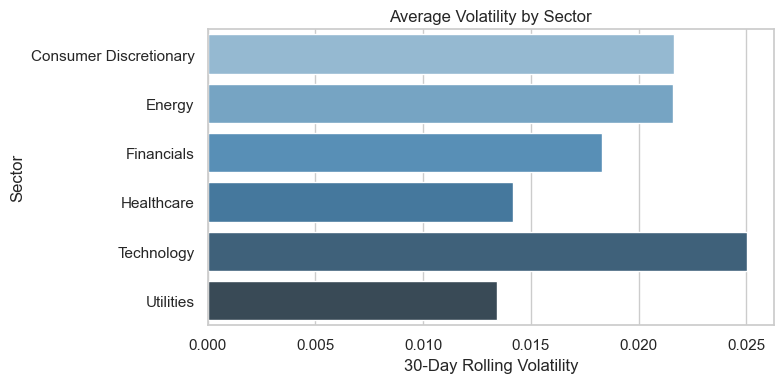

In [45]:
# Plot: Average Rolling Volatility by Sector
plt.figure(figsize=(8, 4))
sns.barplot(
    data=sector_summary,
    x="Rolling_Volatility",
    y="Sector",
    palette="Blues_d",
    hue="Sector",
    legend=False
)

plt.title("Average Volatility by Sector")
plt.xlabel("30-Day Rolling Volatility")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

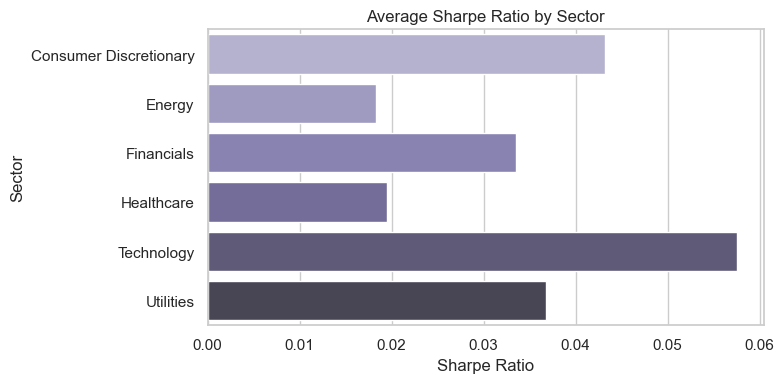

In [46]:
# Plot: Average Sharpe Ratio
plt.figure(figsize=(8, 4))
sns.barplot(data=sector_summary, x="Sharpe_Ratio", y="Sector", palette="Purples_d", hue="Sector", legend=False)
plt.title("Average Sharpe Ratio by Sector")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

### 9. Advanced Sector Insights

In this step, I explore two high-level sector behaviors:

- **Return Correlation:** To assess diversification potential, I compute the correlation matrix of sector-level average daily returns.

- **Recovery After Market Downturns:** I analyze which sectors rebounded most strongly after the COVID-19 crash by calculating cumulative returns from June to December 2020.

These insights provide a deeper understanding of sector interdependencies and resilience during volatile market periods.


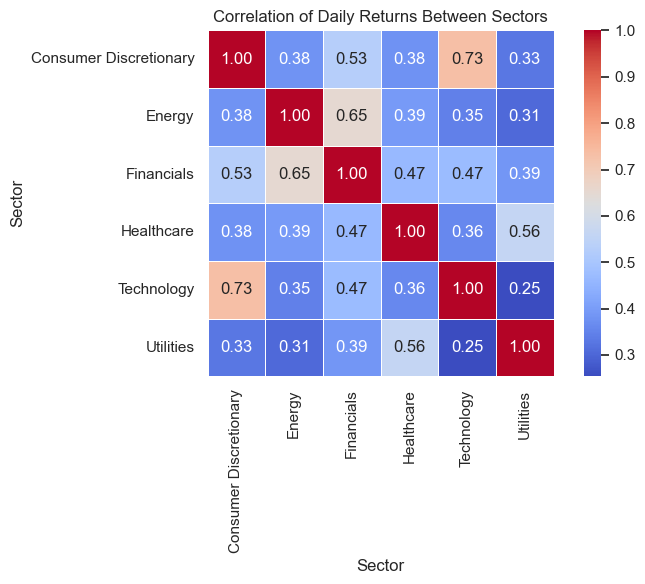

In [49]:
# Calculate average daily return per sector over time
sector_returns = combined_df.groupby(['Date', 'Sector'])['Daily_Return'].mean().reset_index()

# Pivot the table to have sectors as columns and dates as rows
returns_pivot = sector_returns.pivot(index='Date', columns='Sector', values='Daily_Return')

# Compute correlation matrix
correlation_matrix = returns_pivot.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation of Daily Returns Between Sectors')
plt.tight_layout()
plt.show()


#### Summary: Sector Return Correlation

The heatmap above displays the correlation of **daily returns** between sectors from 2018 to 2025.

- **Consumer Discretionary** and **Technology** exhibit the **strongest correlation** (`0.73`), indicating that these sectors often move together—likely due to their shared exposure to economic growth and innovation cycles.

- **Energy** and **Financials** also show a moderate correlation (`0.65`), possibly reflecting joint sensitivity to macroeconomic variables like interest rates and commodity prices.

- **Utilities** display the **weakest correlations** with most other sectors, especially with **Technology (`0.25`)** and **Energy (`0.31`)**, suggesting they operate under more stable, regulated conditions.

- **Healthcare** and **Utilities** are relatively less correlated with the broader market, offering **diversification potential** when included in a balanced portfolio.

These correlations provide valuable insight into co-movements between sectors and support more informed, risk-aware portfolio construction.


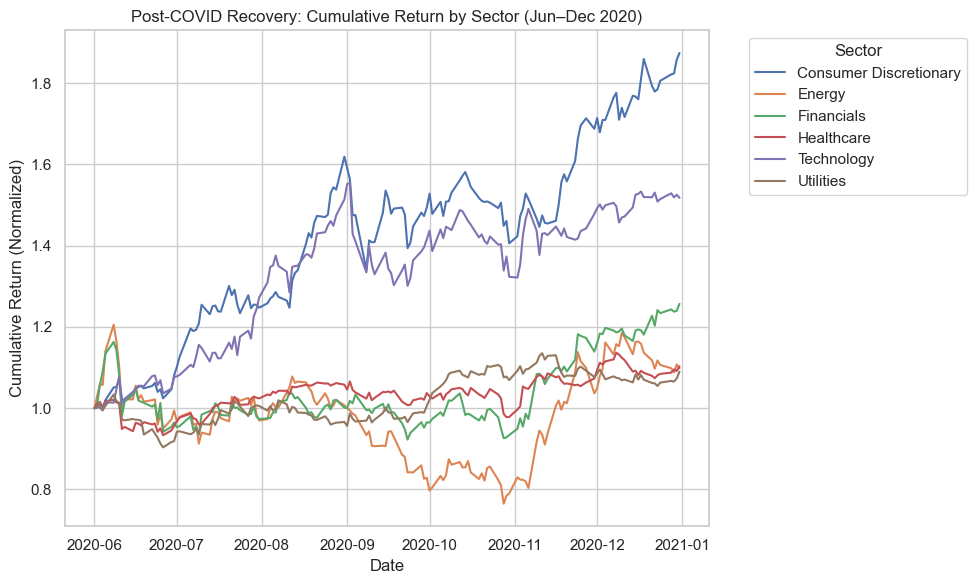

In [50]:
# Filter data: June to December 2020
recovery_period = combined_df[
    (combined_df['Date'] >= '2020-06-01') & 
    (combined_df['Date'] <= '2020-12-31')
]

# Calculate normalized cumulative returns per Ticker
recovery_period = recovery_period.copy()
recovery_period['Cumulative_Return'] = recovery_period.groupby('Ticker')['Close'].transform(
    lambda x: x / x.iloc[0]
)

# Average cumulative return per sector
sector_cum_return = recovery_period.groupby(['Date', 'Sector'])['Cumulative_Return'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=sector_cum_return, x='Date', y='Cumulative_Return', hue='Sector')
plt.title('Post-COVID Recovery: Cumulative Return by Sector (Jun–Dec 2020)')
plt.ylabel('Cumulative Return (Normalized)')
plt.xlabel('Date')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Summary: Sector Performance Post-COVID (Jun–Dec 2020)

This line chart shows normalized cumulative returns of six major sectors from June to December 2020, highlighting recovery trends after the COVID-19 market crash.

- Consumer Discretionary and Technology sectors led the recovery, with strong upward trends.
- Energy showed high volatility and underperformance for most of the period.
- Financials, Healthcare, and Utilities remained relatively stable with modest gains.

Insight: Growth-oriented sectors (Consumer Discretionary, Technology) outperformed during the recovery, suggesting investor confidence in innovation and consumer demand rebound.


### 10. Save Processed Data

In this step. I will save `combined_df` (with features like Daily Returns, Rolling Volatility, and Sharpe Ratios) for future analysis and dashboard development.

**Task:**
- Exported `combined_df` to CSV  
- Saved as `sector_analysis_processed.csv` in the `data/clean/` directory  


In [51]:
# Create path
output_path = Path("../data/clean/sector_analysis_processed.csv")

# Ensure the parent directory exists
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the file
combined_df.to_csv(output_path, index=False)
print(f"Saved processed file to: {output_path}")

Saved processed file to: ..\data\clean\sector_analysis_processed.csv


### 11. Summary and Key Insights

- Technology sector offered the best risk-adjusted performance.
- Utilities and Consumer Discretionary showed more stable returns.
- Energy sector had the lowest Sharpe ratio and highest volatility.
- COVID-19 created a sharp dip, but Tech recovered the fastest.
- Correlation matrix showed diversification benefits between Tech and Utilities.

This analysis can help investors build diversified portfolios and manage sector exposure based on volatility and return performance.